<a href="https://colab.research.google.com/github/bsttiv/tipos_espectrales/blob/main/Tipos_Espectrales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Limpieza de los datos**

In [1]:
# Se monta el drive para cargar los datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Se importa pandas para procesar los datos
import pandas as pd
import numpy as np

In [3]:
# Tipos espectrales en los q estamos interesados
tipos_espectrales = ["O", "B", "A", "F", "G", "K", "M"]

In [4]:
# Funciones que se usan en el parámetro converters del método read_csv
# Su objetivo es filtrar los datos y eliminar aquellos que no estén en el formato correcto

def texto_a_float(texto):
  try:
    return np.float64(texto.strip())
  except Exception:
    return np.nan

def texto_mayuscula_primera_letra(texto):
  try:
    return texto.strip().upper()[0]
  except Exception:
    return "NaN"

In [5]:
# Ruta de la base de datos
ruta = "drive/MyDrive/Modulo/Tipos_Espectrales/hip_main.dat"
# Nombres de las columnas (según la especificación de https://heasarc.gsfc.nasa.gov/w3browse/all/hipparcos.html)
names = ["H"+str(i) for i in range(0, 78)]
# Se lee la base de datos con los parámetros adecuados
df = pd.read_csv(ruta, sep="|", converters={"H76": texto_mayuscula_primera_letra, "H32": texto_a_float, "H37": texto_a_float, "H40": texto_a_float}, names=names, keep_default_na=False)
# Se eliminan aquellas filas cuyo tipo espectral no coincida con los buscados (O, B, A, F, G, K, M)
df = df[df["H76"].isin(tipos_espectrales)]
# Se borran las columnas que no se usarán
labels = ["H"+str(i) for i in range(0, 78) if i not in [76, 32, 37, 40]]
df.drop(labels=labels, inplace=True, axis=1)
# Se eliminan todas las filas que posiblemente no tengan valores definidos
df.dropna(axis=0, inplace=True)
# Se muestra el DataFrame
df

<ipython-input-5-3a6df1d0f274>:6: DtypeWarning: Columns (5,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, sep="|", converters={"H76": texto_mayuscula_primera_letra, "H32": texto_a_float, "H37": texto_a_float, "H40": texto_a_float}, names=names, keep_default_na=False)


,H32,H37,H40,H76
0,9.643,0.482,0.55,F
1,10.519,0.999,1.04,K
2,6.576,-0.019,0.00,B
3,8.471,0.370,0.43,F
4,9.693,0.902,0.90,G
...,...,...,...,...
118213,9.107,1.595,1.61,K
118214,9.019,0.639,0.70,G
118215,8.868,0.999,0.98,K
118216,10.077,0.698,0.75,G


In [6]:
# Se extraen las filas de cada tipo espectral para posteriormente usar el método describe
# Y visualizar las estadísticas de los datos

df_tipo_o = df[df["H76"] == "O"]
df_tipo_b = df[df["H76"] == "B"]
df_tipo_a = df[df["H76"] == "A"]
df_tipo_f = df[df["H76"] == "F"]
df_tipo_g = df[df["H76"] == "G"]
df_tipo_k = df[df["H76"] == "K"]
df_tipo_m = df[df["H76"] == "M"]

In [22]:
len(df_tipo_o)

255

In [7]:
df_tipo_o.describe()

,H32,H37,H40
count,255.000000,255.000000,255.000000
mean,8.008573,0.222824,0.258627
std,1.822831,0.302070,0.317725
min,1.566000,-0.335000,-0.370000
25%,7.060000,0.009000,0.030000
50%,8.176000,0.169000,0.180000
75%,9.246500,0.405000,0.480000
max,11.624000,1.408000,1.390000


In [8]:
df_tipo_b.describe()

,H32,H37,H40
count,10341.000000,10341.000000,10341.000000
mean,7.843250,0.046298,0.067571
std,1.489189,0.187834,0.199207
min,0.312000,-0.400000,-0.420000
25%,7.008000,-0.066000,-0.040000
50%,7.986000,-0.004000,0.020000
75%,8.846000,0.101000,0.110000
max,12.843000,1.910000,2.480000


In [9]:
df_tipo_a.describe()

,H32,H37,H40
count,18550.000000,18550.000000,18550.000000
mean,8.230618,0.179759,0.205729
std,1.209015,0.147032,0.158022
min,1.248000,-0.400000,-0.290000
25%,7.582000,0.075000,0.090000
50%,8.350000,0.170000,0.190000
75%,9.025000,0.267000,0.300000
max,11.934000,1.745000,2.160000


In [10]:
df_tipo_f.describe()

,H32,H37,H40
count,25306.000000,25306.000000,25306.000000
mean,9.071121,0.476358,0.542513
std,1.158848,0.117243,0.116609
min,-0.417000,-0.400000,-0.160000
25%,8.407000,0.408000,0.480000
50%,9.132000,0.472000,0.540000
75%,9.845000,0.530000,0.600000
max,12.839000,2.180000,2.780000


In [11]:
df_tipo_g.describe()

,H32,H37,H40
count,22409.000000,22409.000000,22409.000000
mean,9.536064,0.787254,0.817905
std,1.075112,0.206393,0.171363
min,3.418000,-0.400000,-0.100000
25%,8.977000,0.624000,0.690000
50%,9.656000,0.740000,0.790000
75%,10.240000,0.955000,0.950000
max,12.869000,2.215000,2.960000


In [12]:
df_tipo_k.describe()

,H32,H37,H40
count,31378.000000,31378.000000,31378.000000
mean,9.710005,1.202528,1.193795
std,1.124681,0.233951,0.247679
min,1.629000,-0.400000,-0.060000
25%,9.081000,1.040000,1.020000
50%,9.850500,1.165000,1.130000
75%,10.456000,1.365000,1.350000
max,13.130000,2.867000,3.510000


In [13]:
df_tipo_m.describe()

,H32,H37,H40
count,4148.000000,4148.000000,4148.000000
mean,10.171799,1.561587,2.269812
std,1.352534,0.209219,0.684430
min,2.849000,0.000000,0.010000
25%,9.362000,1.483000,1.840000
50%,10.350500,1.589000,2.150000
75%,11.130500,1.659000,2.560000
max,13.247000,3.315000,5.750000


Los campos a utilizar serán "H32" (que corresponde a magnitud); "H37", "H40" (índices de color); y "H76" (tipo espectral)

https://heasarc.gsfc.nasa.gov/w3browse/all/hipparcos.html

# **Visualización de los datos**

In [14]:
import matplotlib.pyplot as plt

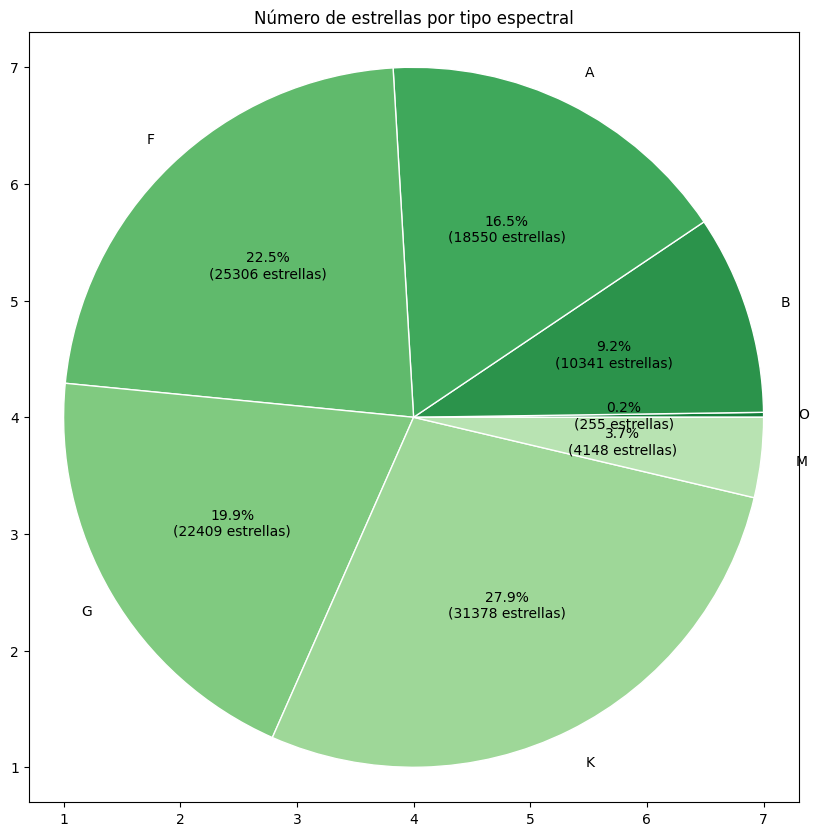

In [45]:
_, ax = plt.subplots(figsize=(10,10))

n_tipos = [len(df_tipo_o), len(df_tipo_b), len(df_tipo_a), len(df_tipo_f), len(df_tipo_g), len(df_tipo_k), len(df_tipo_m)]

n_datos = np.sum(n_tipos)

def func(pct):
    absolute = int(np.round(pct/100.*n_datos))
    return f"{pct:.1f}%\n({absolute:d} estrellas)"

colors = plt.get_cmap('Greens_r')(np.linspace(0.2, 0.7, len(n_tipos)))
ax.pie(n_tipos, labels=tipos_espectrales, autopct=lambda pct: func(pct), colors=colors, radius=3, center=(4, 4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

ax.set_title("Número de estrellas por tipo espectral")
ax.set_aspect("equal")


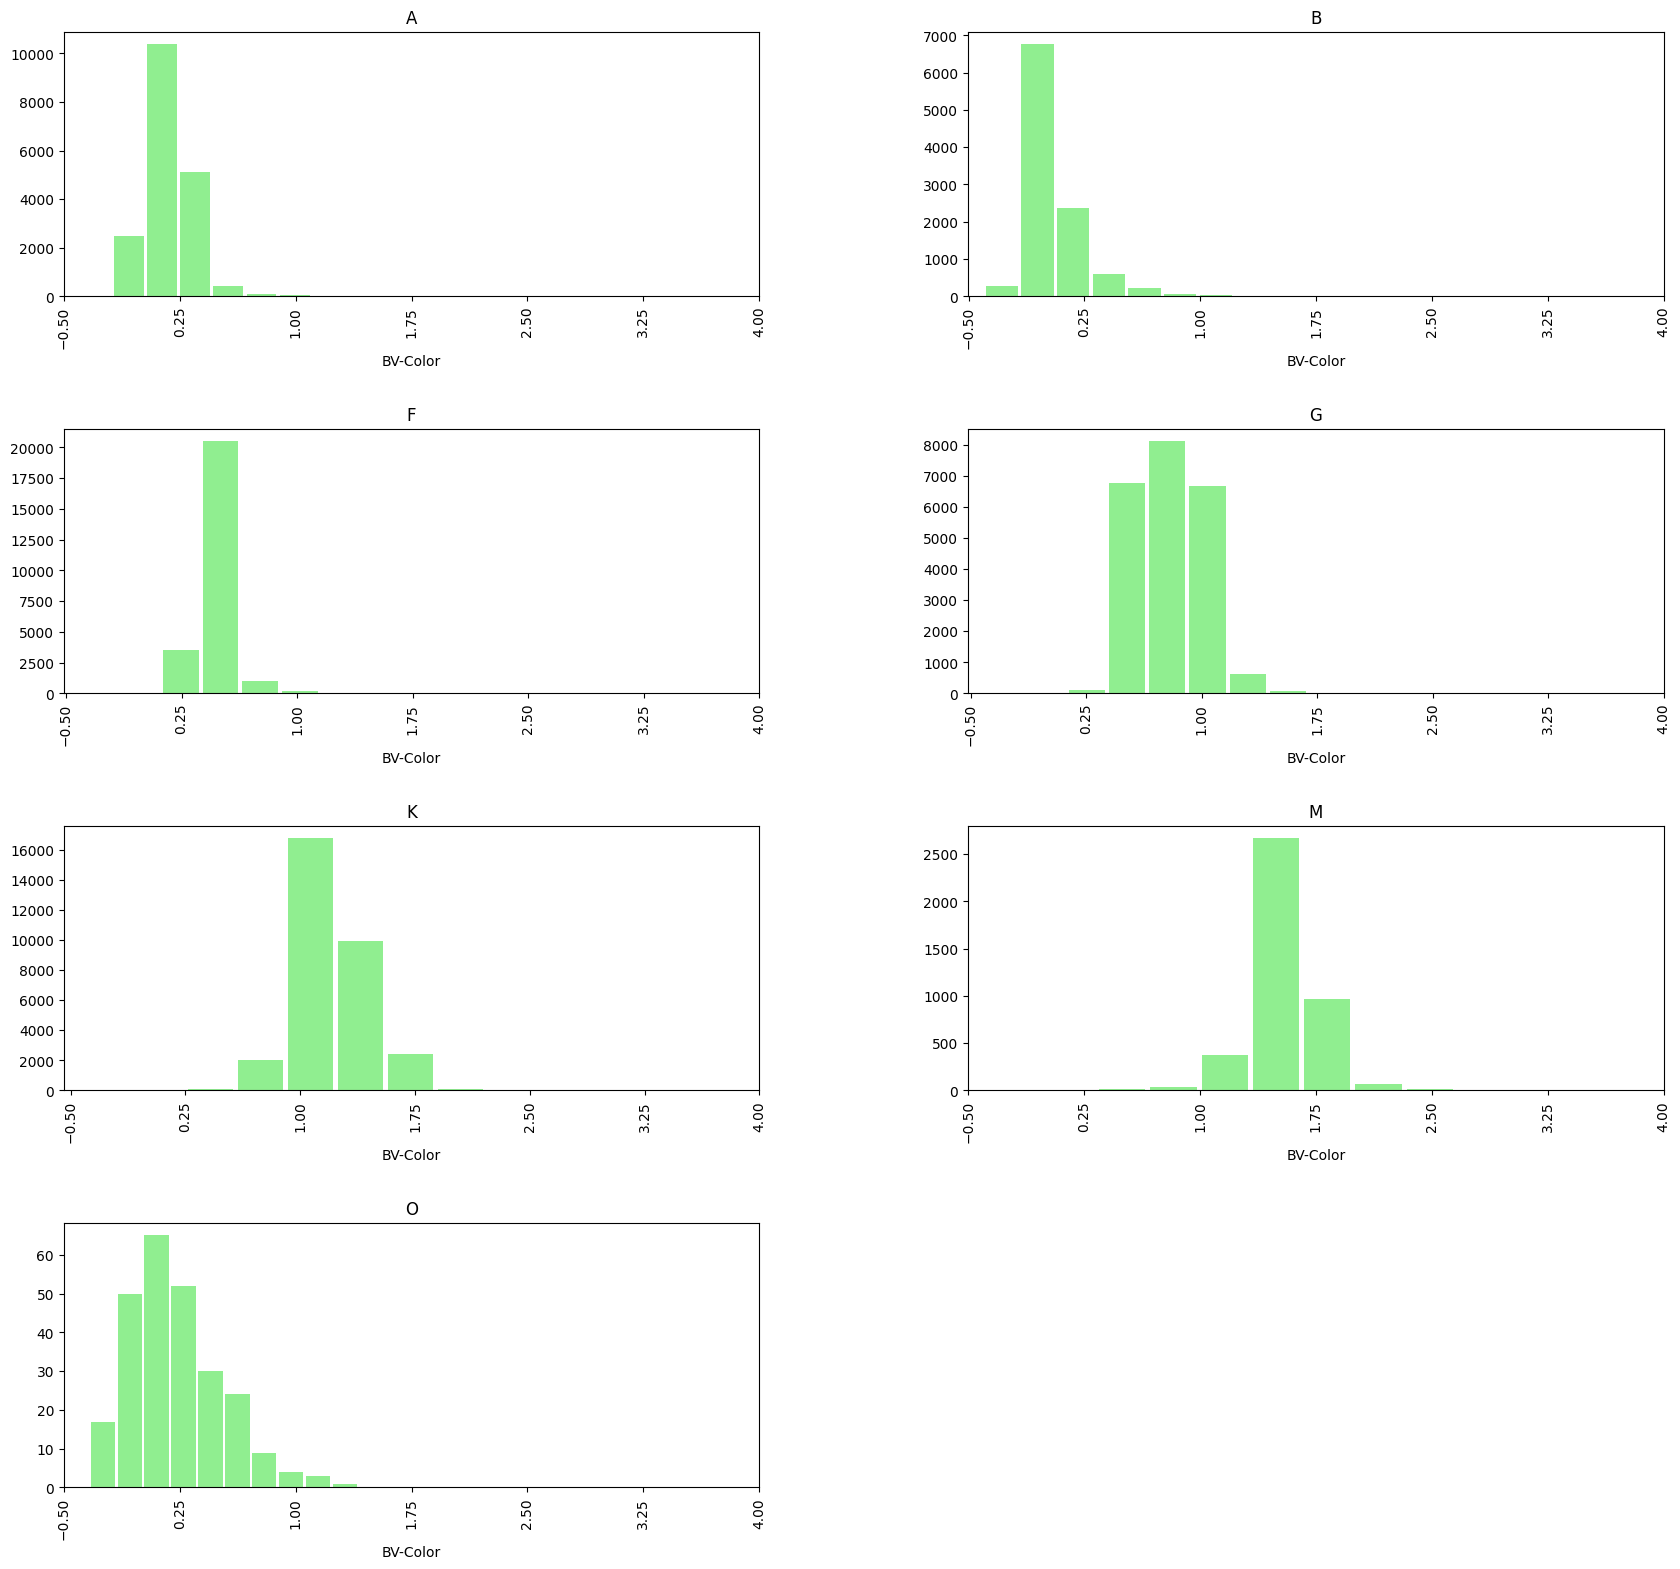

In [46]:
# Histograma BV-Color
ax = df.hist(column="H37", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("BV-Color")
    x.set_xticks(np.linspace(-0.5, 4, 7))

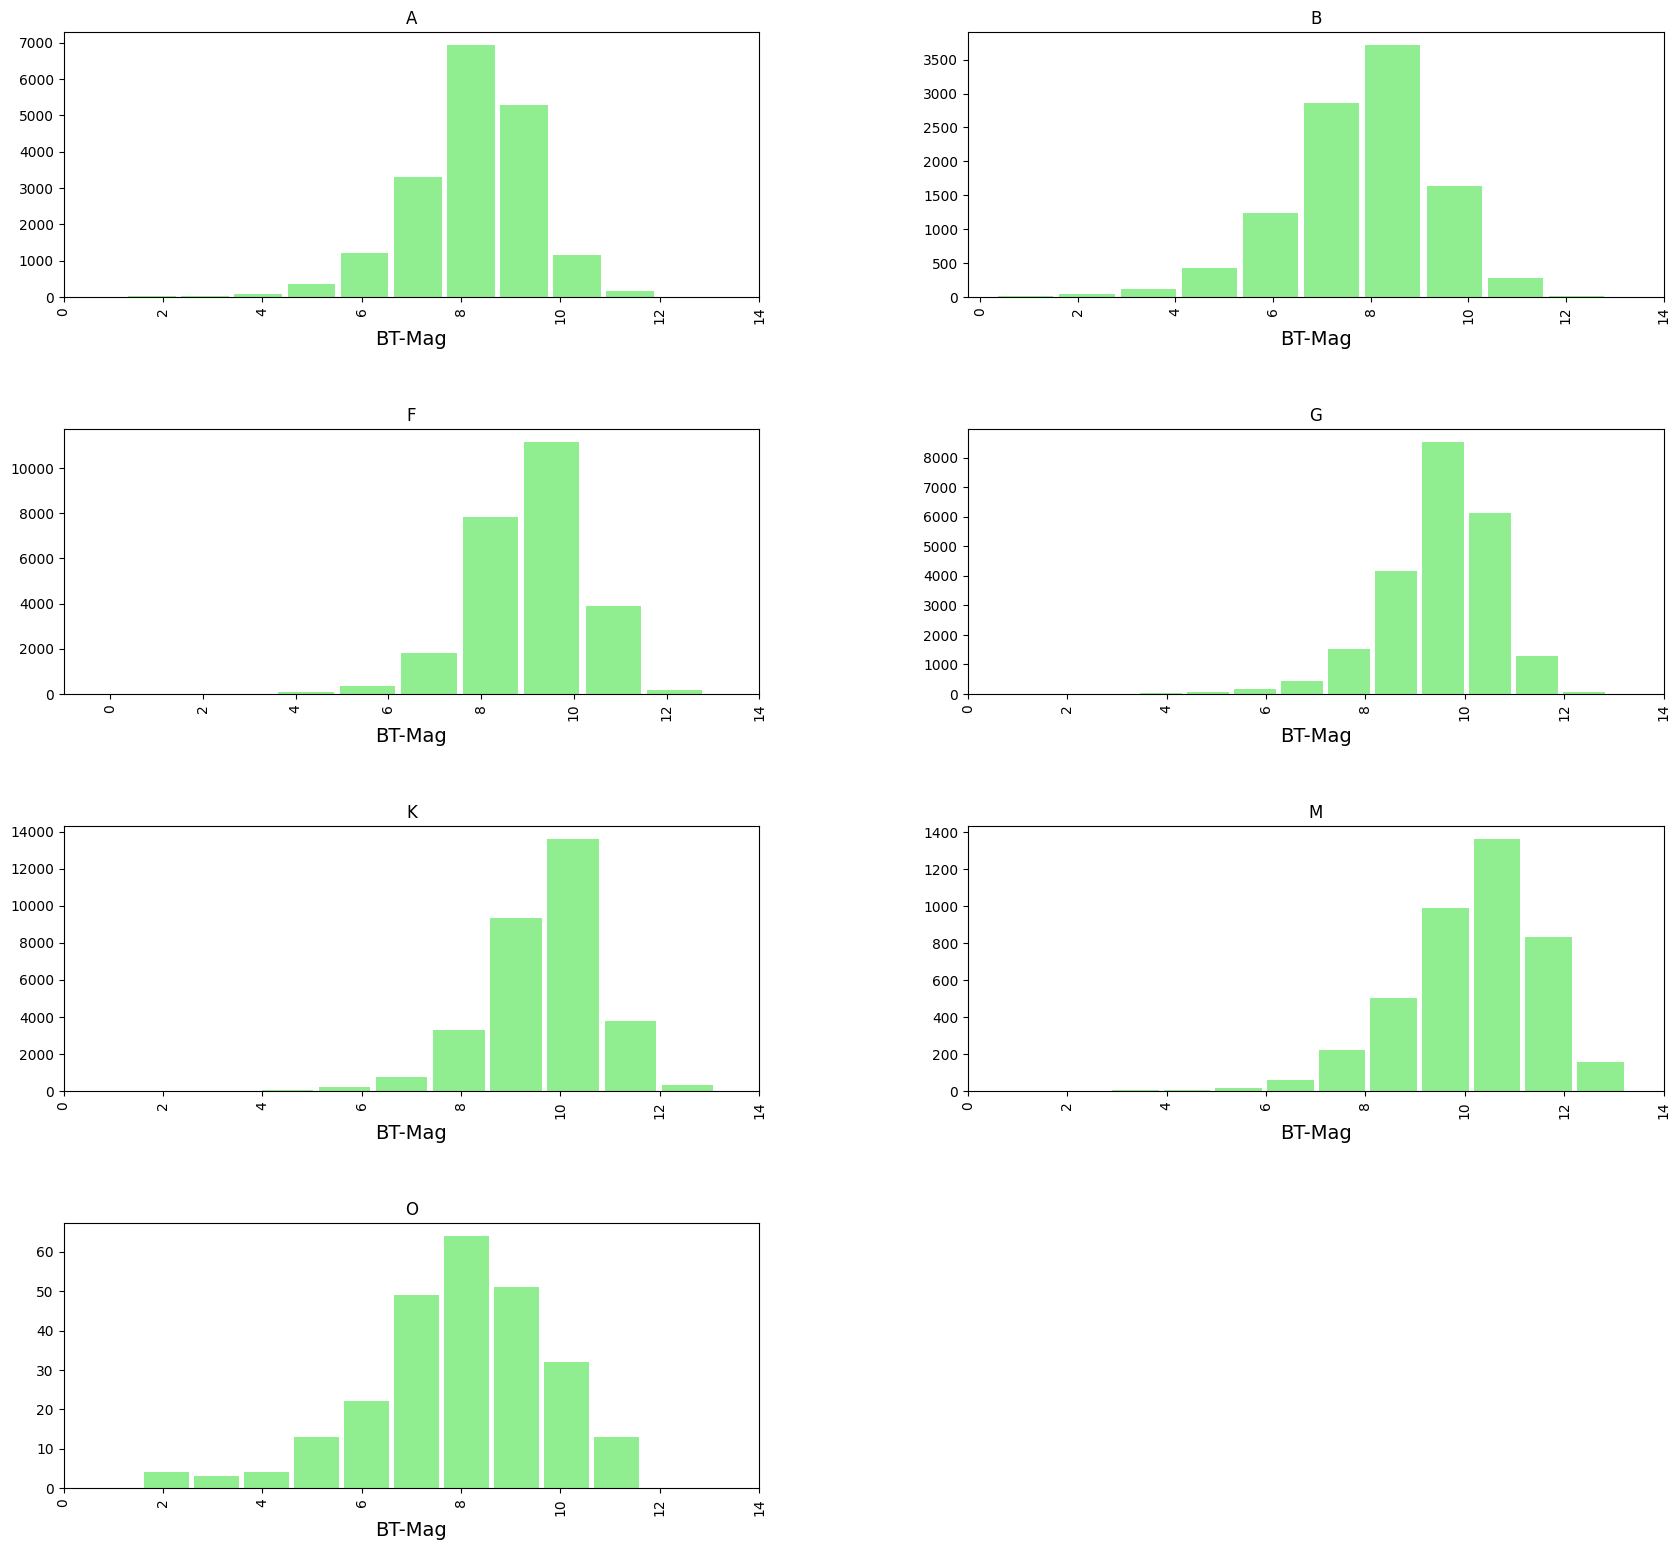

In [ ]:
# Histograma BT-Mag
ax = df.hist(column="H32", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("BT-Mag", size=14)
    x.set_xticks(range(0, 15, 2))

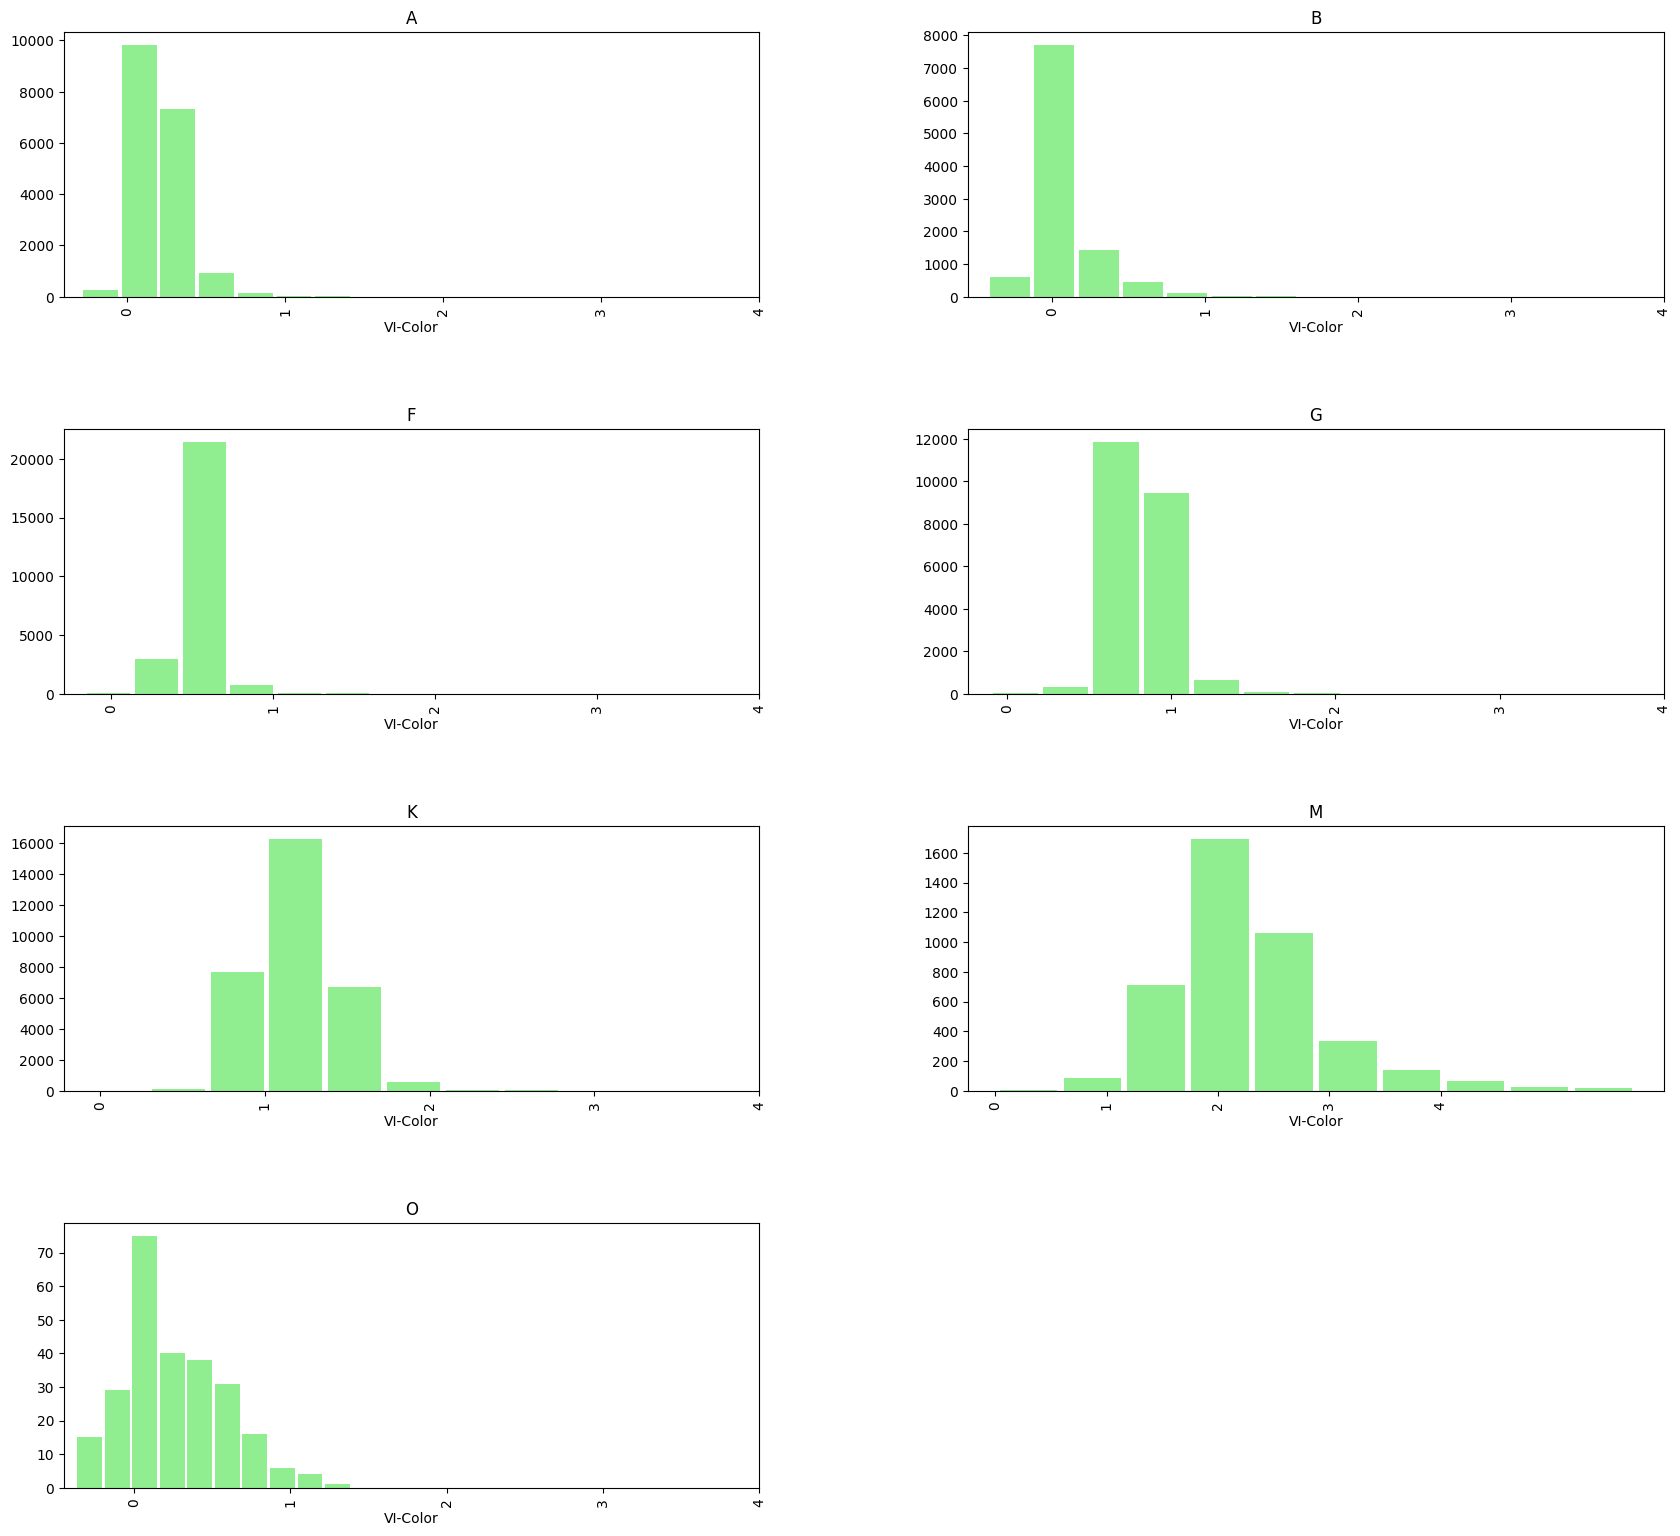

In [ ]:
# Histograma VI-Color
ax = df.hist(column="H40", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("VI-Color")
    x.set_xticks(np.linspace(0, 4, 5))

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seabo

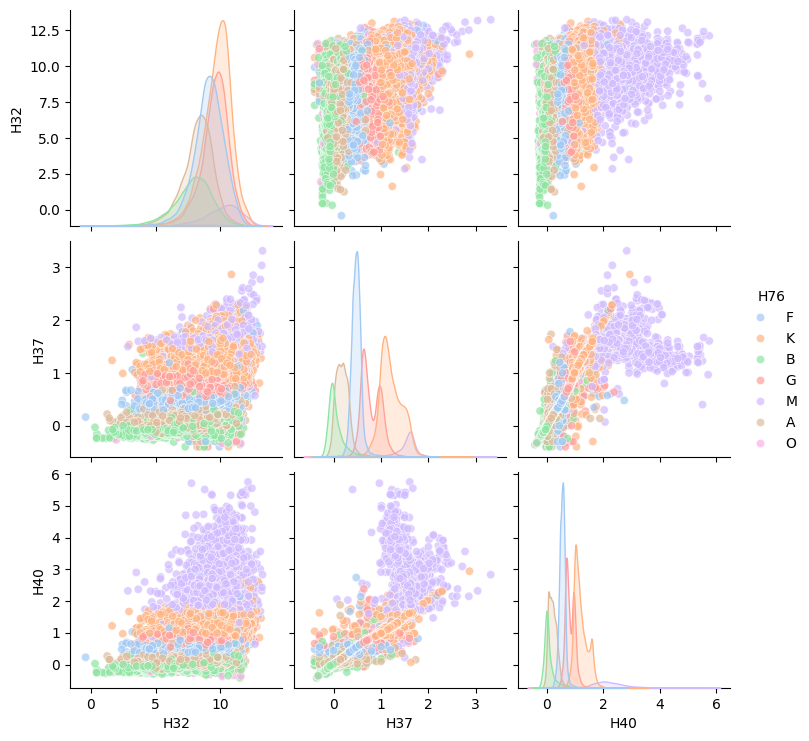

In [ ]:
import seaborn as sns

sns.pairplot(df, hue = 'H76', diag_kind = 'kde', palette= sns.color_palette("pastel"), plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(fill=True))

# **Modelo: Random Forest**

https://youtube.com/watch?v=AYICIq5jnhU&si=3e1M0dp2M4Jl7j5Y

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [ ]:
from sklearn.model_selection import train_test_split

columns = ["H32", "H37", "H40"]

x = df.loc[:, columns]
y = df.loc[:, ['H76']]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3453, train_size = .25)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint

# Tuning de parametros basado en: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

split = x_train.size/100
params = {  'min_samples_split' : int(split),
            'min_samples_leaf' : int(split/10),
            'max_depth' : 6,
            'max_features' : 'sqrt',
}

random_forest = RandomForestClassifier(**params)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=3453)

grid_search = GridSearchCV(random_forest, param_grid = { 'n_estimators': range(15, 81, 10) }, n_jobs=-1, cv=cv)

grid_search.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=3453),
             estimator=RandomForestClassifier(max_depth=6, min_samples_leaf=84,
                                              min_samples_split=842),
             n_jobs=-1, param_grid={'n_estimators': range(15, 81, 10)})

In [ ]:
print("Precisión en primera etapa de tuneo: ", grid_search.score(x_test, y_test))

Precisión en primera etapa de tuneo:  0.768860257916029


In [ ]:
params = {
            'min_samples_leaf' : int(split/10),
            'n_estimators' : 65,
            'max_features' : 'sqrt',
}
random_forest = RandomForestClassifier(**params)
grid_search = GridSearchCV(random_forest, param_grid={'max_depth':range(5,21,5), 'min_samples_split':range(200,1001,200)} ,n_jobs=-1, cv=cv)
grid_search.fit(x_train, y_train.values.ravel())

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=3453),
             estimator=RandomForestClassifier(min_samples_leaf=84,
                                              n_estimators=65),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 21, 5),
                         'min_samples_split': range(200, 1001, 200)})

In [ ]:
print("Precisión en segunda etapa de tuneo: ", grid_search.score(x_test, y_test))

Precisión en segunda etapa de tuneo:  0.7715651730315217


In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

oversample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
over_x, over_y = oversample.fit_resample(x, y)
over_x_train, over_x_test, over_y_train, over_y_test = train_test_split(over_x, over_y, test_size=0.25, stratify=over_y)

In [ ]:
random_forest = RandomForestClassifier(max_depth=20, min_samples_leaf=84, min_samples_split=200,
                       n_estimators=100)
random_forest.fit(over_x_train, over_y_train.values.ravel())

RandomForestClassifier(max_depth=20, min_samples_leaf=84, min_samples_split=200)

In [ ]:
random_forest.fit(over_x_train, over_y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=84, min_samples_split=200)

In [ ]:
random_forest.score(x_test, y_test.values.ravel())

0.7543035436760746

In [ ]:
predicted = grid_search.predict(x_test)

Text(0.5, 1.0, 'Matriz de confusión de Random Forest')

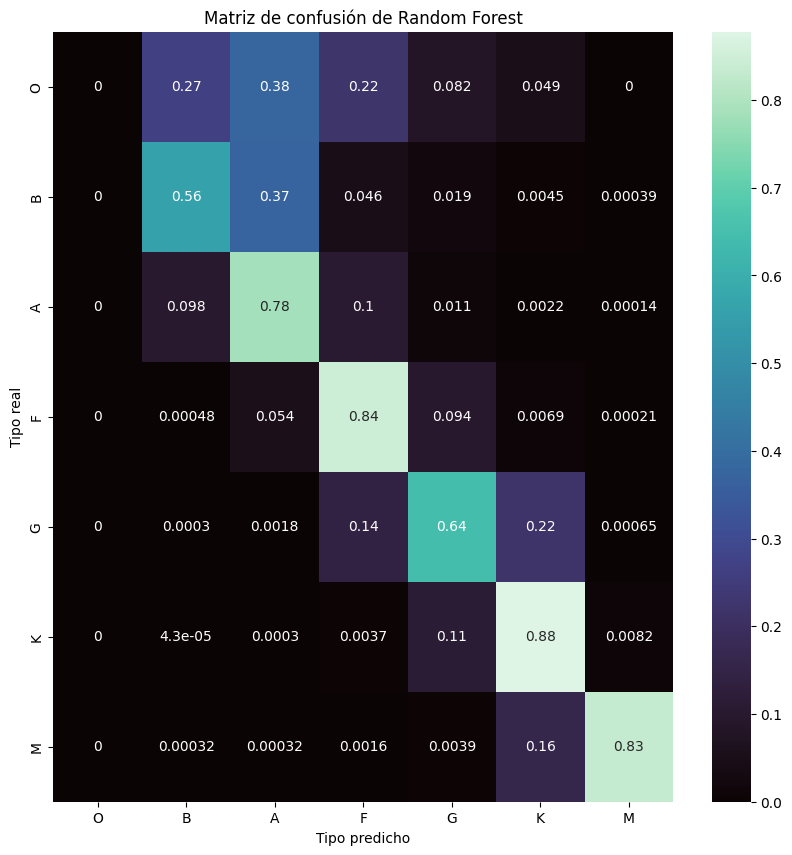

In [ ]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de Random Forest")

In [138]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predicted)

print(report)

NameError: name 'y_test' is not defined

# **Modelo: Gradient Boosting**

https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {  'min_samples_split' : int(split),
            'min_samples_leaf' : int(split/10),
            'max_depth' : 6,
            'max_features' : 'sqrt',
            'subsample' : 0.8
}

gradient_boosting = GradientBoostingClassifier(**params)

grid_search = GridSearchCV(gradient_boosting, param_grid = { 'n_estimators': range(15, 81, 10) }, n_jobs=4, cv=5)

grid_search.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=6,
                                                  max_features='sqrt',
                                                  min_samples_leaf=84,
                                                  min_samples_split=842,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(15, 81, 10)})

In [ ]:
print("Precisión en primera etapa de tuneo: ", grid_search.score(x_test, y_test))

# La segunda etapa de tuneo no se realiza, porque se demora más de 40 minutos y la precisión no sube mucho más.

Precisión en primera etapa de tuneo:  0.774578543379483


Text(0.5, 1.0, 'Matriz de confusión de Gradient Boosting')

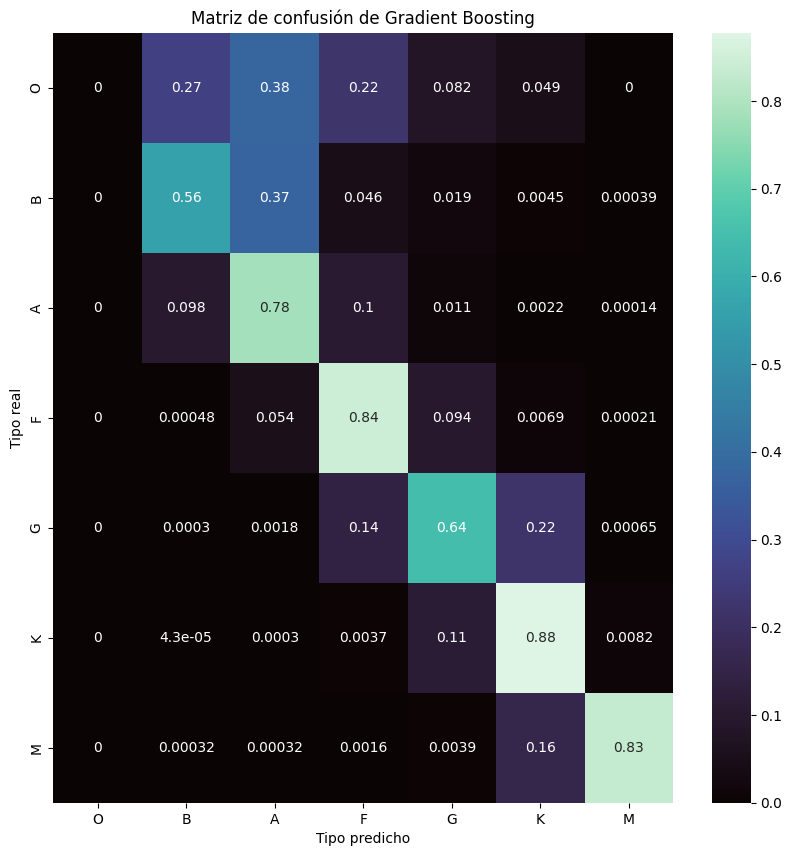

In [ ]:
predicted = grid_search.predict(x_test)

cm = pd.DataFrame(confusion_matrix(y_test, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de Gradient Boosting")

In [ ]:
report = classification_report(y_test, predicted)

print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.73      0.78      0.76     13927
           B       0.75      0.56      0.64      7776
           F       0.79      0.84      0.82     18935
           G       0.70      0.64      0.67     16887
           K       0.83      0.88      0.85     23484
           M       0.92      0.83      0.88      3098
           O       0.00      0.00      0.00       184

    accuracy                           0.77     84291
   macro avg       0.67      0.65      0.66     84291
weighted avg       0.77      0.77      0.77     84291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Modelo: K-Vecinos más cercanos**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,50)]
scores = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classifier, x_train, y_train.values.ravel(), cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Precisión')

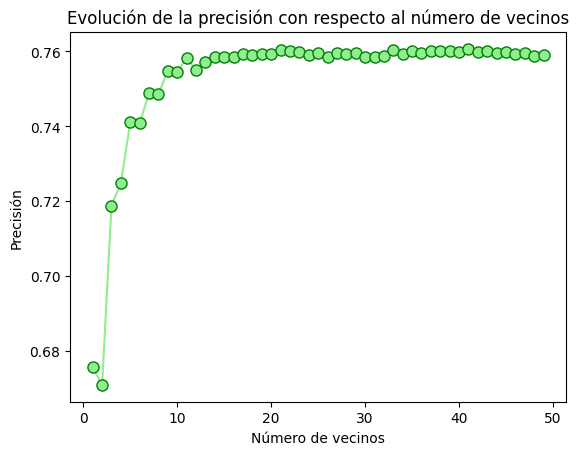

In [ ]:
plt.plot(k_values, scores, marker = 'o', color='lightgreen', ms=8, mec='g')
plt.title("Evolución de la precisión con respecto al número de vecinos")
plt.xlabel("Número de vecinos")
plt.ylabel("Precisión")

In [ ]:
best_k = k_values[np.argmax(scores)]
print(best_k)

41


In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=41)

In [ ]:
knn.score(x_test, y_test)

0.7633911093711072

In [ ]:
predicted = knn.predict(x_test)

Text(0.5, 1.0, 'Matriz de confusión de K-Vecinos más cercanos')

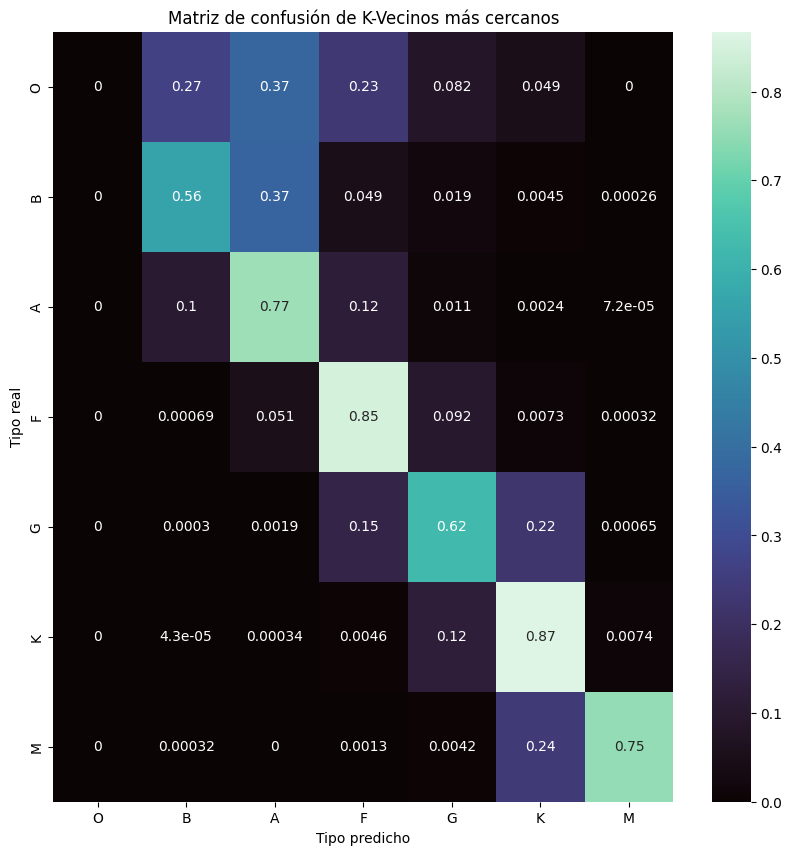

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de K-Vecinos más cercanos")

In [ ]:
report = classification_report(y_test, predicted)

print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           A       0.73      0.77      0.75     13927
           B       0.74      0.56      0.64      7776
           F       0.77      0.85      0.81     18935
           G       0.68      0.62      0.65     16887
           K       0.81      0.87      0.84     23484
           M       0.92      0.75      0.83      3098
           O       0.00      0.00      0.00       184

    accuracy                           0.76     84291
   macro avg       0.67      0.63      0.65     84291
weighted avg       0.76      0.76      0.76     84291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Modelo: Red Neuronal**

Referencia: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [147]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [148]:
train_df, test_df = train_test_split(df, test_size=.25)

In [149]:
train_labels = train_df.pop("H76")
test_labels = test_df.pop("H76")

In [150]:
train_features = np.array(train_df)
test_features = np.array(test_df)

In [151]:
encoder = LabelEncoder()
encoder.fit(tipos_espectrales)
train_labels_enc = encoder.transform(train_labels)
test_labels_enc = encoder.transform(test_labels)

In [152]:
train_labels_enc = keras.utils.to_categorical(train_labels_enc, num_classes=7)
test_labels_enc = keras.utils.to_categorical(test_labels_enc, num_classes=7)

In [153]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


In [154]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.BinaryAccuracy(name='accuracy')
]

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [155]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_focal_crossentropy',
    metrics=METRICS
)

In [156]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 839 (3.28 KB)

 Trainable params: 839 (3.28 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
result = model.fit(train_features, train_labels_enc, batch_size=2048, epochs=80)

Epoch 1/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8564 - fn: 44592.4180 - fp: 535.2558 - loss: 0.3583 - precision: 0.3681 - tn: 269033.3125 - tp: 335.6744
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - fn: 43742.7227 - fp: 941.8605 - loss: 0.2848 - precision: 0.5369 - tn: 268626.6875 - tp: 1185.3721
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - fn: 41611.5117 - fp: 1943.0000 - loss: 0.2404 - precision: 0.6320 - tn: 267625.5625 - tp: 3316.5813
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - fn: 39811.8828 - fp: 2734.3721 - loss: 0.2069 - precision: 0.6531 - tn: 266834.1875 - tp: 5116.2095
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - fn: 38635.0938 - fp: 3311.3257 - loss: 0.1824 - precision: 0.6564 - tn: 266257.2188 - tp: 6293.0000
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8685 - fn: 37645.0469 - fp: 3669.4187 - loss: 0.1645 - precision: 0.6652 - tn: 2658

In [158]:
metric_names = ['loss']
metric_names.extend([m.name for m in METRICS])
precision_ev_1 = model.history.history['precision']
loss_ev_1 = model.history.history['loss']
epochs = np.arange(80)

In [159]:
results = model.evaluate(x=test_features, y=test_labels_enc)
for (metric_name, value) in zip(metric_names, results):
  print(f"{metric_name}: {value}")

879/879 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9092 - fn: 6394.0044 - fp: 2521.8762 - loss: 0.0713 - precision: 0.7515 - tn: 82053.4844 - tp: 7701.8887
loss: 0.07139164209365845
tp: 15415.0
fp: 5042.0
tn: 163540.0
fn: 12682.0
precision: 0.753531813621521
accuracy: 0.9098841547966003


Text(0, 0.5, 'Precisión')

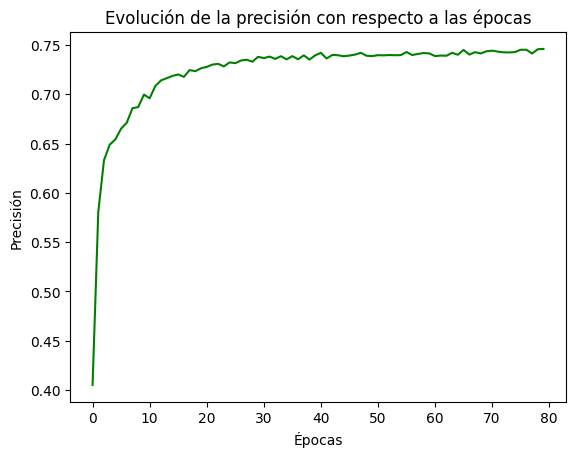

In [163]:
plt.plot(epochs, precision_ev_1, color='green')
plt.title("Evolución de la precisión con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("Precisión")

Text(0, 0.5, 'Función de costos')

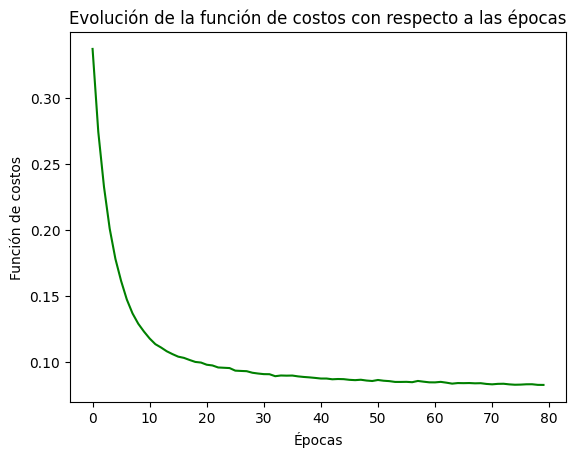

In [164]:
plt.plot(epochs,loss_ev_1, color="green")
plt.title("Evolución de la función de costos con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("Función de costos")

In [165]:
from sklearn.metrics import confusion_matrix

pred = model.predict(test_features)
pred = np.argmax(pred, axis = 1)
test_labels = np.argmax(test_labels_enc, axis=1)

879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Text(0.5, 1.0, 'Matriz de confusión de la red neuronal')

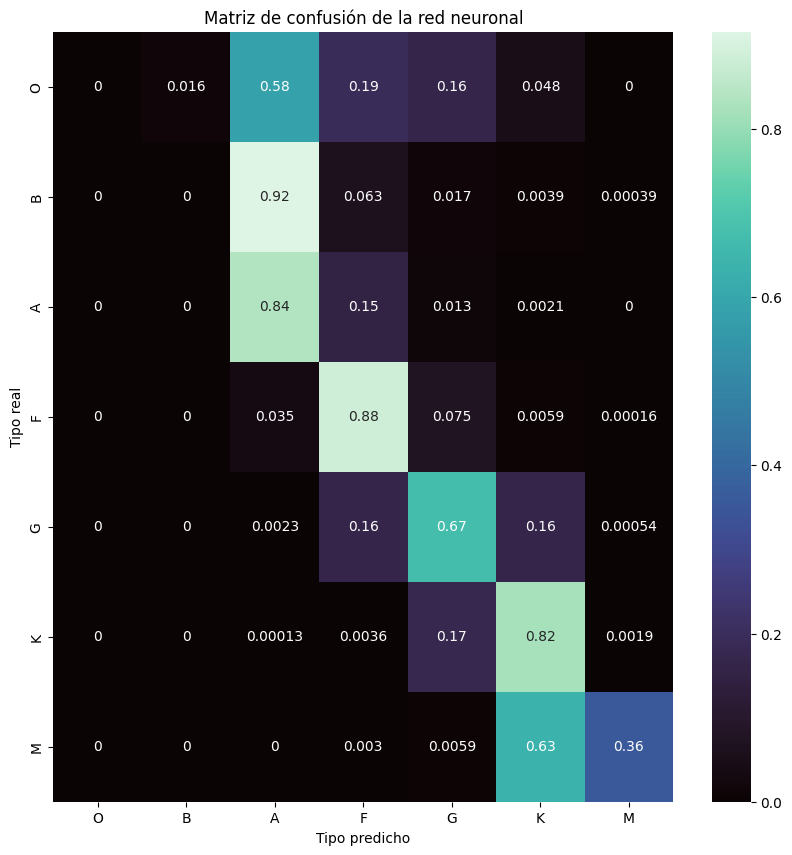

In [166]:
import seaborn as sns
_, ax = plt.subplots(figsize=(10,10))
cm = pd.DataFrame(confusion_matrix(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred), normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))

ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de la red neuronal")

In [167]:
tf.keras.backend.clear_session(
    free_memory=True
)

In [168]:
num_values = train_labels.value_counts()

In [169]:
class_weights = dict(enumerate([ len(train_labels) / num_values[c] / 7 for c in encoder.classes_ ]))
class_weights

{0: 0.8698568642222474,
 1: 1.550132411357952,
 2: 0.6341265243787756,
 3: 0.7152190883480977,
 4: 0.5118784463283699,
 5: 3.8385172366683364,
 6: 62.39082161361954}

In [170]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True)

In [171]:
result = model.fit(train_features, train_labels_enc, batch_size=2048, epochs=80, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8927 - fn: 28465.7910 - fp: 6601.0698 - loss: 0.2240 - precision: 0.7202 - tn: 262967.5000 - tp: 16462.3027
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8764 - fn: 35140.3945 - fp: 3659.6047 - loss: 0.1453 - precision: 0.7259 - tn: 265908.9688 - tp: 9787.6973
Epoch 3/80
 1/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8809 - fn: 1572.0000 - fp: 136.0000 - loss: 0.1282 - precision: 0.7778 - tn: 12152.0000 - tp: 476.0000

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,fn,fp,loss,precision,tn,tp
  current = self.get_monitor_value(logs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - fn: 34888.5117 - fp: 3113.4651 - loss: 0.1422 - precision: 0.7651 - tn: 266455.0938 - tp: 10039.5811
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8774 - fn: 35251.3711 - fp: 3215.0000 - loss: 0.1422 - precision: 0.7465 - tn: 266353.5625 - tp: 9676.7207
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8793 - fn: 34693.5352 - fp: 3249.2092 - loss: 0.1395 - precision: 0.7598 - tn: 266319.3438 - tp: 10234.5586
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8799 - fn: 34093.9531 - fp: 3620.3721 - loss: 0.1326 - precision: 0.7490 - tn: 265948.1875 - tp: 10834.1396
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8802 - fn: 34328.8125 - fp: 3376.7673 - loss: 0.1346 - precision: 0.7579 - tn: 266191.7812 - tp: 10599.2793
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - fn: 34355.7656 - fp: 3402.0930 - loss: 0.1361 - precision: 0.7581 - tn: 266166.46

In [172]:
precision_ev_2 = model.history.history['precision']
loss_ev_2 = model.history.history['loss']
epochs = np.arange(80)

Text(0, 0.5, 'Precisión')

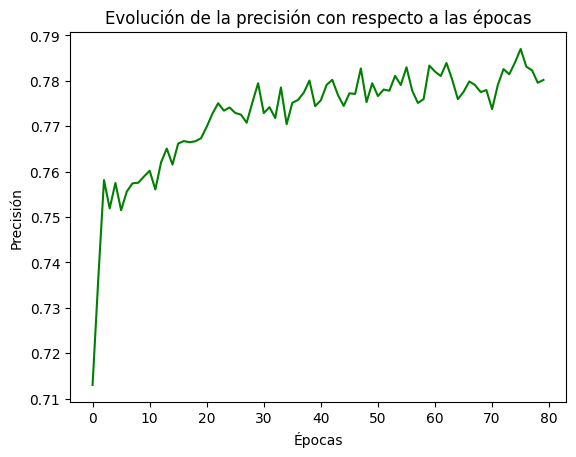

In [173]:
plt.plot(epochs, precision_ev_2, color="green")
plt.title("Evolución de la precisión con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("Precisión")

Text(0, 0.5, 'Función de costos')

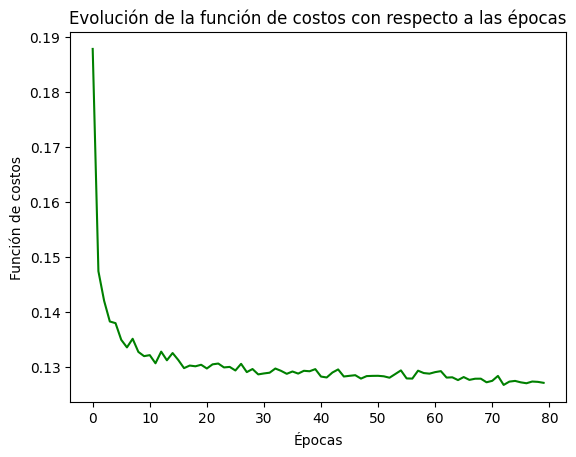

In [174]:
plt.plot(epochs, loss_ev_2, color="green")
plt.title("Evolución de la función de costos con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("Función de costos")

In [175]:
results = model.evaluate(x=test_features, y=test_labels_enc)

879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8896 - fn: 10411.2227 - fp: 453.4398 - loss: 0.1000 - precision: 0.8877 - tn: 84121.9219 - tp: 3684.6704


In [176]:
for (metric_name, value) in zip(metric_names, results):
  print(f"{metric_name}: {value}")

loss: 0.09997125715017319
tp: 7321.0
fp: 909.0
tn: 167673.0
fn: 20776.0
precision: 0.8895504474639893
accuracy: 0.8897444009780884


In [177]:
pred = model.predict(test_features)
pred = np.argmax(pred, axis = 1)
test_labels = np.argmax(test_labels_enc, axis=1)

879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Text(0.5, 1.0, 'Matriz de confusión de la red neuronal')

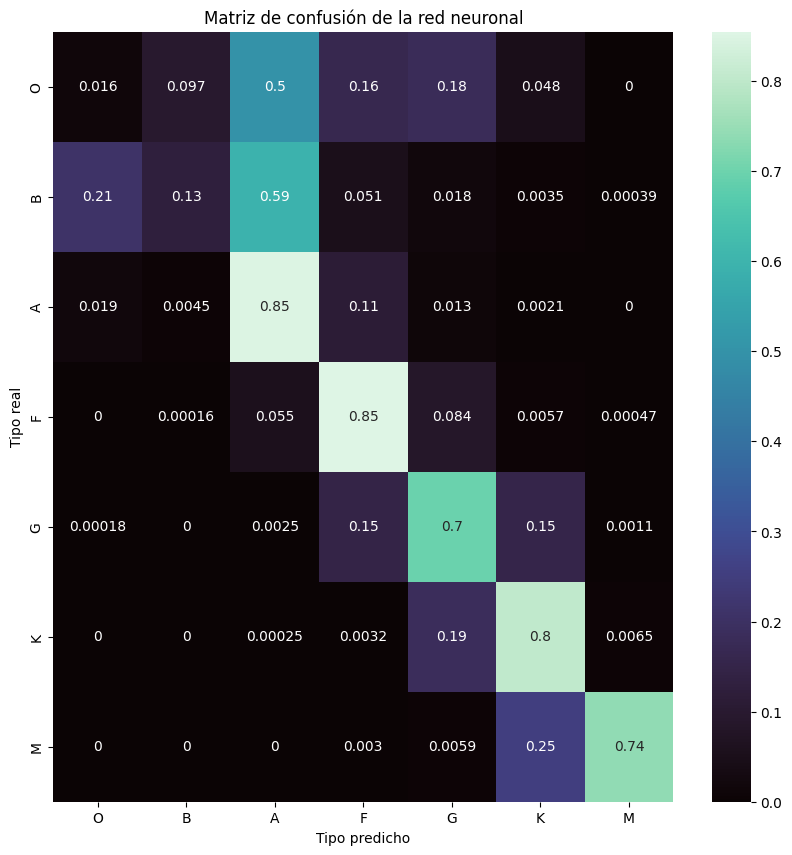

In [178]:
import seaborn as sns
_, ax = plt.subplots(figsize=(10,10))
cm = pd.DataFrame(confusion_matrix(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred), normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))

ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de la red neuronal")

In [179]:
report = classification_report(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred))

print(report)

              precision    recall  f1-score   support

           A       0.68      0.85      0.75      4707
           B       0.92      0.13      0.22      2573
           F       0.78      0.85      0.82      6317
           G       0.65      0.70      0.67      5573
           K       0.84      0.80      0.82      7854
           M       0.92      0.74      0.82      1011
           O       0.00      0.02      0.00        62

    accuracy                           0.74     28097
   macro avg       0.68      0.58      0.59     28097
weighted avg       0.77      0.74      0.72     28097

